# PHÂN TÍCH CHẤT LƯỢNG RƯỢU TRẮNG

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Bộ dữ liệu về chất lượng rượu vang, có sẵn tại UCI Machine Learning Repository, chứa thông tin về các loại rượu vang đỏ và trắng từ vùng phía Bắc Bồ Đào Nha. Bộ dữ liệu này được sử dụng rộng rãi trong các nghiên cứu về học máy và phân tích dữ liệu nhằm dự đoán chất lượng của rượu dựa trên các đặc tính hóa học của nó.
- Bộ dữ liệu này được cung cấp bởi Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos và José Reis.
- Bao gồm hai tệp riêng biệt cho rượu vang đỏ và rượu vang trắng.
- Mỗi tệp chứa các giá trị về các thuộc tính hóa học và một cột chỉ số chất lượng (quality) từ 0 đến 10.

## Bảng phân công công việc

## Phát biểu bài toán

Mục tiêu của đồ án này là giải quyết phương trình mô hình cuối cùng và xuất ra các giá trị thống kê như R-squared điều chỉnh, Mean Squared Error (MSE), Root Mean Squared Error (RMSE) và Mean Absolute Error (MAE). Đồng thời, đồ án sẽ kiểm tra mô hình bằng cách sử dụng các số liệu và hình ảnh minh họa để đánh giá tính tuyến tính của các tham số mô hình, kiểm tra tính độc lập tuần tự của các sai số, tính đồng nhất của phương sai (heteroscedasticity), tính bình thường của phân phối phần dư và đa cộng tuyến (multicollinearity). Ngoài ra, đồ án cũng sẽ xem xét các yếu tố khác như liệu có bất kỳ giá trị ngoại lệ (outliers) nào không và liệu có dữ liệu bị thiếu hay không. Cuối cùng, mô hình sẽ được kiểm tra bằng cách sử dụng bộ dữ liệu kiểm tra và kết quả sẽ được thảo luận chi tiết.

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)
library(MLmetrics)
library(pls)
library(gridExtra)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
response_variable = 1 

# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("../../data/part2/wine+quality/winequality-white.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	4898 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ free.sulfur.dioxide : num  45 14 30 47 47 30 30 45 14 28 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ density             : num  1.001 0.994 0.995 0.996 0.996 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...


## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 4898 dòng và 12 cột
dim(raw_data)

[1] 4898   12

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- (raw_data[duplicated(raw_data), ])
length(duplicates)

[1] 12

In [6]:
clean_data <- unique(raw_data)

In [7]:
duplicates <- clean_data[duplicated(clean_data), ]
if (nrow(duplicates) == 0) {
  print("No duplicates found. Data is clean.")
} else {
  print("Duplicates still exist:")
  print(duplicates)
}

dim(raw_data)
dim(clean_data)

[1] "No duplicates found. Data is clean."


[1] 4898   12

[1] 3961   12

### Mỗi cột mang ý nghĩa gì?

In [8]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	4898 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ free.sulfur.dioxide : num  45 14 30 47 47 30 30 45 14 28 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ density             : num  1.001 0.994 0.995 0.996 0.996 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...


Dưới đây là mô tả chi tiết về các đặc trưng trong bộ dữ liệu này:

| Tên biến             | Vai trò   | Kiểu     | Mô tả                                             | Đơn vị | Giá trị bị thiếu |
| -------------------- | --------- | -------- | ------------------------------------------------- | ------ | ---------------- |
| fixed_acidity        | Đặc trưng | Liên tục | Độ axit cố định (hầu hết là axit tartaric)        | g/dm³  | Không            |
| volatile_acidity     | Đặc trưng | Liên tục | Độ axit bay hơi (chủ yếu là axit acetic)          | g/dm³  | Không            |
| citric_acid          | Đặc trưng | Liên tục | Hàm lượng axit citric                             | g/dm³  | Không            |
| residual_sugar       | Đặc trưng | Liên tục | Lượng đường còn lại sau khi lên men               | g/dm³  | Không            |
| chlorides            | Đặc trưng | Liên tục | Lượng muối                                        | g/dm³  | Không            |
| free_sulfur_dioxide  | Đặc trưng | Liên tục | Lượng SO2 tự do                                   | mg/dm³ | Không            |
| total_sulfur_dioxide | Đặc trưng | Liên tục | Tổng lượng SO2                                    | mg/dm³ | Không            |
| density              | Đặc trưng | Liên tục | Mật độ của rượu                                   | g/cm³  | Không            |
| pH                   | Đặc trưng | Liên tục | Độ pH của rượu                                    |        | Không            |
| sulphates            | Đặc trưng | Liên tục | Lượng muối sunphat                                | g/dm³  | Không            |
| alcohol              | Đặc trưng | Liên tục | Phần trăm cồn trong rượu                          | %      | Không            |
| quality              | Mục tiêu  | Nguyên   | Điểm chất lượng của rượu (thang điểm từ 0 đến 10) |        | Không            |


### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [9]:
wine_quality_white <- raw_data

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [10]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [11]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(wine_quality_white) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(wine_quality_white) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable             missing   min lower median upper     max
   <chr>                  <dbl> <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1 fixed.acidity              0 3.8     6.3    6.8   7.3  14.2  
 2 volatile.acidity           0 0.08    0.2    0.3   0.3   1.1  
 3 citric.acid                0 0       0.3    0.3   0.4   1.66 
 4 residual.sugar             0 0.6     1.7    5.2   9.9  65.8  
 5 chlorides                  0 0.009   0      0     0     0.346
 6 free.sulfur.dioxide        0 2      23     34    46   289    
 7 total.sulfur.dioxide       0 9     108    134   167   440    
 8 density                    0 0.987   1      1     1     1.04 
 9 pH                         0 2.72    3.1    3.2   3.3   3.82 
10 sulphates                  0 0.22    0.4    0.5   0.6   1.08 
11 alcohol                    0 8       9.5   10.4  11.4  14.2  
12 quality                    0 3       5      6     6     9    


In [12]:
print(summary(as.data.frame(wine_quality_white) %>% select_if(is.numeric)))

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 5.200  
 Mean   : 6.855   Mean   :0.2782   Mean   :0.3342   Mean   : 6.391  
 3rd Qu.: 7.300   3rd Qu.:0.3200   3rd Qu.:0.3900   3rd Qu.: 9.900  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:108.0        1st Qu.:0.9917  
 Median :0.04300   Median : 34.00      Median :134.0        Median :0.9937  
 Mean   :0.04577   Mean   : 35.31      Mean   :138.4        Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.: 46.00      3rd Qu.:167.0        3rd Qu.:0.9961  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Không có cột nào có kiểu dữ liệu phân loại

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [13]:
names(wine_quality_white)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"

### Khảo sát chất lượng rượu trắng

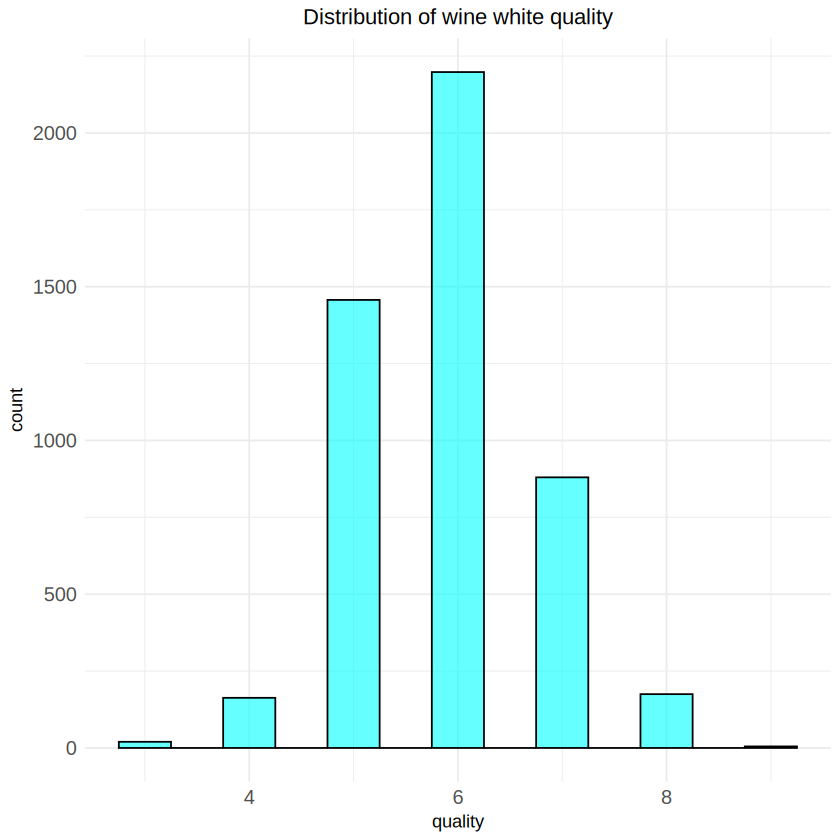

In [14]:
ggplot(wine_quality_white, aes(x = quality)) +
  geom_histogram(binwidth = 0.5, fill = "cyan", color = "black", alpha = 0.6) +
  theme_minimal() +
  ggtitle("Distribution of wine white quality") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Nhận xét:
- Chất lượng rượu có phân phối đối xứng 
- Hầu hết chất lượng rượu đỏ nằm ở mức 5, 6
- Không có rượu đỏ nào đạt điểm tuyệt đối
- Chất lượng rượu đỏ tệ nhất có điểm số là 3

### Khảo sát tính chua (acidity) trong rượu trắng

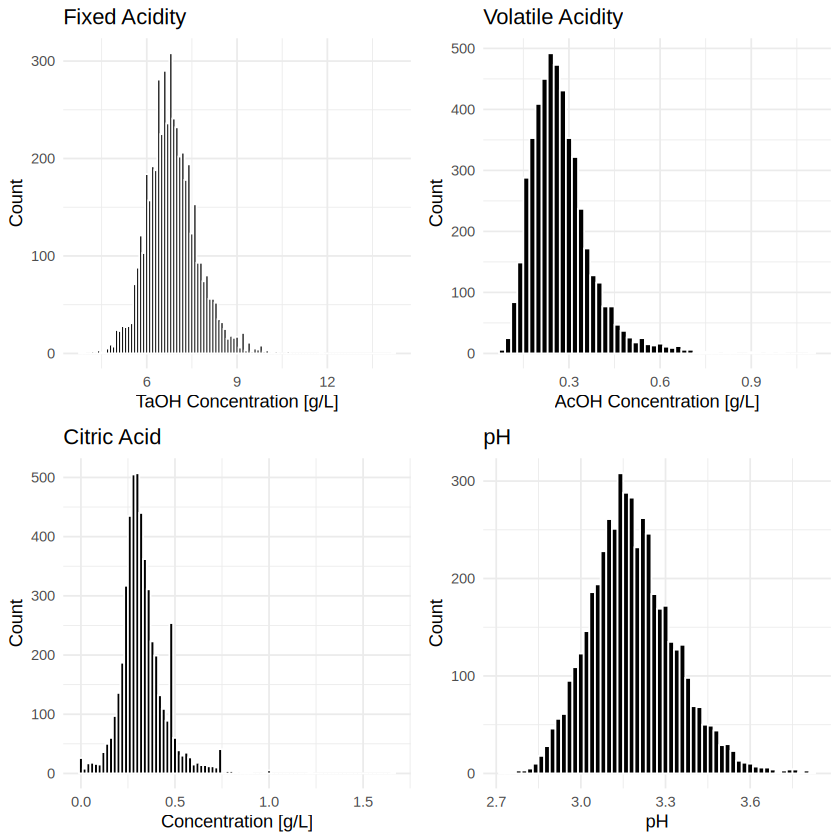

In [15]:
p1 <- ggplot(wine_quality_white, aes(x = fixed.acidity)) +
  geom_histogram(binwidth = 0.1, fill = "black", color = "white") +
  labs(title = "Fixed Acidity", x = "TaOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p2 <- ggplot(wine_quality_white, aes(x = volatile.acidity)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Volatile Acidity", x = "AcOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p3 <- ggplot(wine_quality_white, aes(x = citric.acid)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Citric Acid", x = "Concentration [g/L]", y = "Count") +
  theme_minimal()

p4 <- ggplot(wine_quality_white, aes(x = pH)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "pH", x = "pH", y = "Count") +
  theme_minimal()

# Arrange the plots in a grid
grid.arrange(p1, p2, p3, p4, nrow = 2)

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


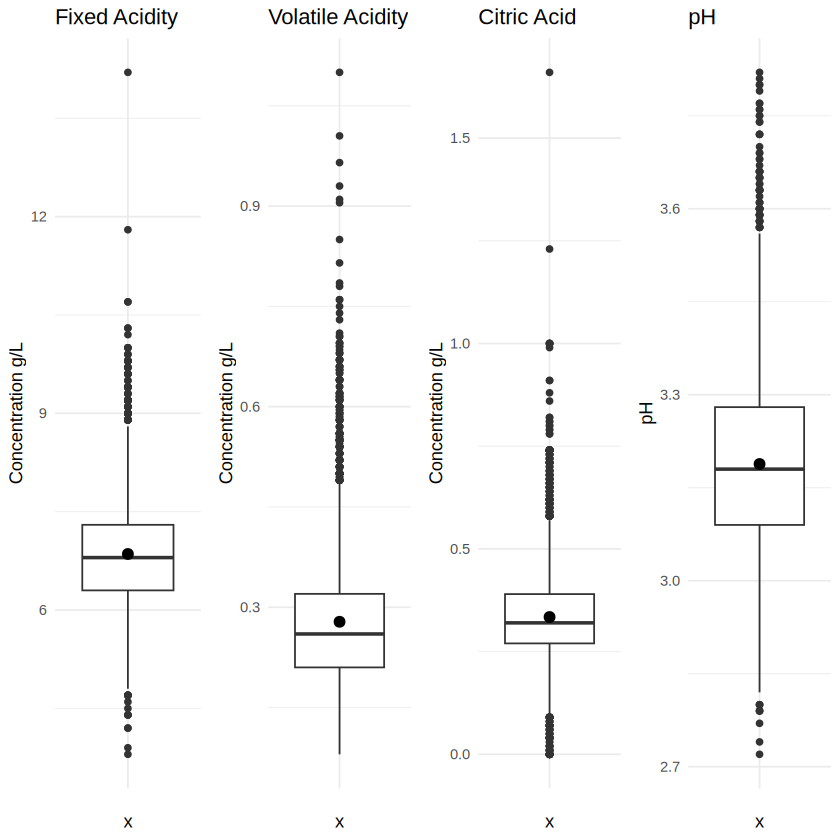

In [16]:
p1 <- ggplot(wine_quality_white, aes(x = "", y = fixed.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Fixed Acidity", y = "Concentration g/L") +
  theme_minimal()

p2 <- ggplot(wine_quality_white, aes(x = "", y = volatile.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Volatile Acidity", y = "Concentration g/L") +
  theme_minimal()

p3 <- ggplot(wine_quality_white, aes(x = "", y = citric.acid)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Citric Acid", y = "Concentration g/L") +
  theme_minimal()

p4 <- ggplot(wine_quality_white, aes(x = "", y = pH)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "pH", y = "pH") +
  theme_minimal()

# Arrange the plots in a single row
grid.arrange(p1, p2, p3, p4, ncol = 4)

### Khảo sát hàm lượng lưu huỳnh trong rượu trắng

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


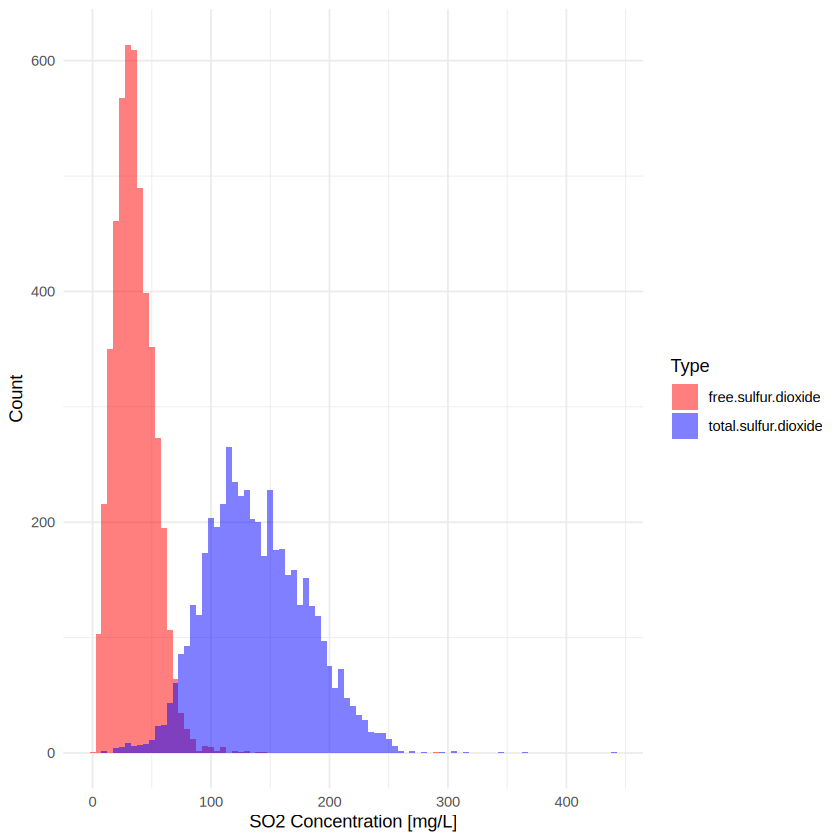

In [17]:
wine_data_long <- data.frame(
  value = c(wine_quality_white$free.sulfur.dioxide, wine_quality_white$total.sulfur.dioxide),
  type = rep(c("free.sulfur.dioxide", "total.sulfur.dioxide"), each = nrow(wine_quality_white))
)


ggplot(wine_data_long, aes(x = value, fill = type)) +
  geom_histogram(aes(y = ..count..), binwidth = 5, position = "identity", alpha = 0.5) +
  labs(x = "SO2 Concentration [mg/L]", y = "Count", fill = "Type") +
  scale_fill_manual(values = c("red", "blue")) +
  theme_minimal() +
  theme(legend.position = "right")

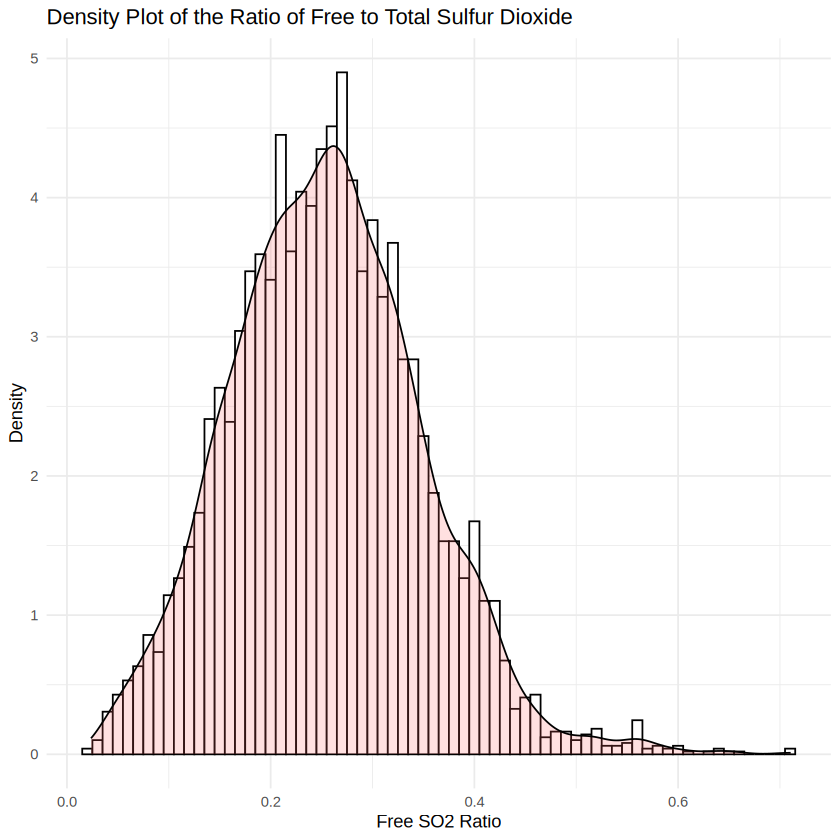

In [18]:
wine_combined <- wine_quality_white %>%
  mutate(ratio_sulfur_dioxide = free.sulfur.dioxide / total.sulfur.dioxide)

ggplot(wine_combined, aes(x = ratio_sulfur_dioxide)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.01, fill = "white", color = "black") +
  geom_density(alpha = 0.2, fill = "#FF6666") +
  labs(title = "Density Plot of the Ratio of Free to Total Sulfur Dioxide",
       x = "Free SO2 Ratio",
       y = "Density") +
  theme_minimal()

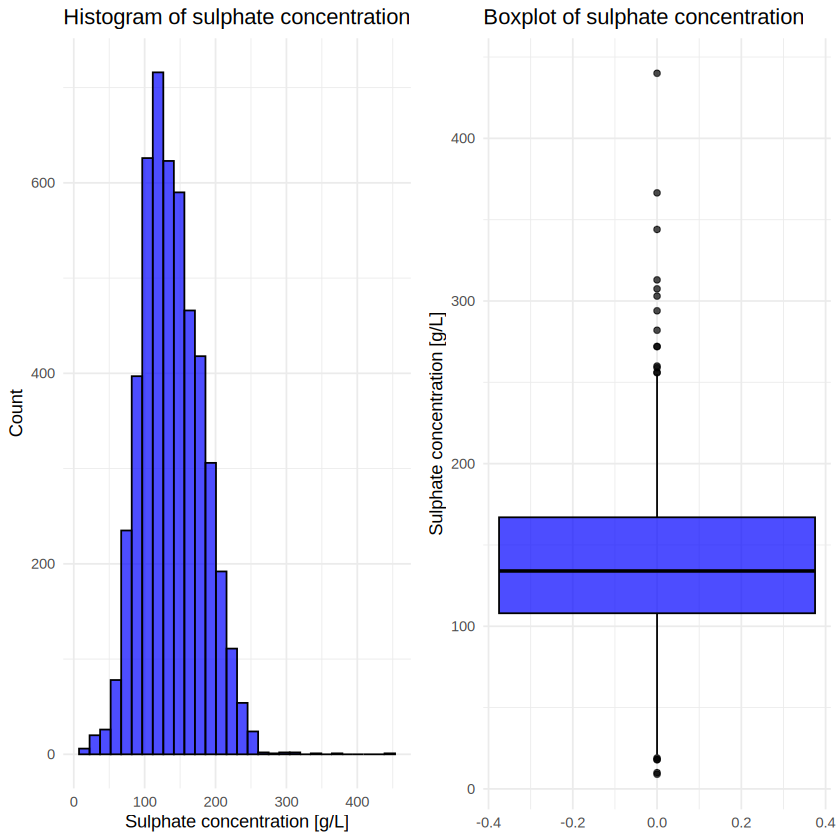

In [19]:
hist_plot <- ggplot(wine_quality_white, aes(x = total.sulfur.dioxide)) +
  geom_histogram(fill = "blue", color = "black", alpha = 0.7, bins = 30) +
  labs(title = "Histogram of sulphate concentration", x = "Sulphate concentration [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_white, aes(y = total.sulfur.dioxide)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of sulphate concentration", y = "Sulphate concentration [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát lượng đường còn lại sau khi lên men trong rượu trắng

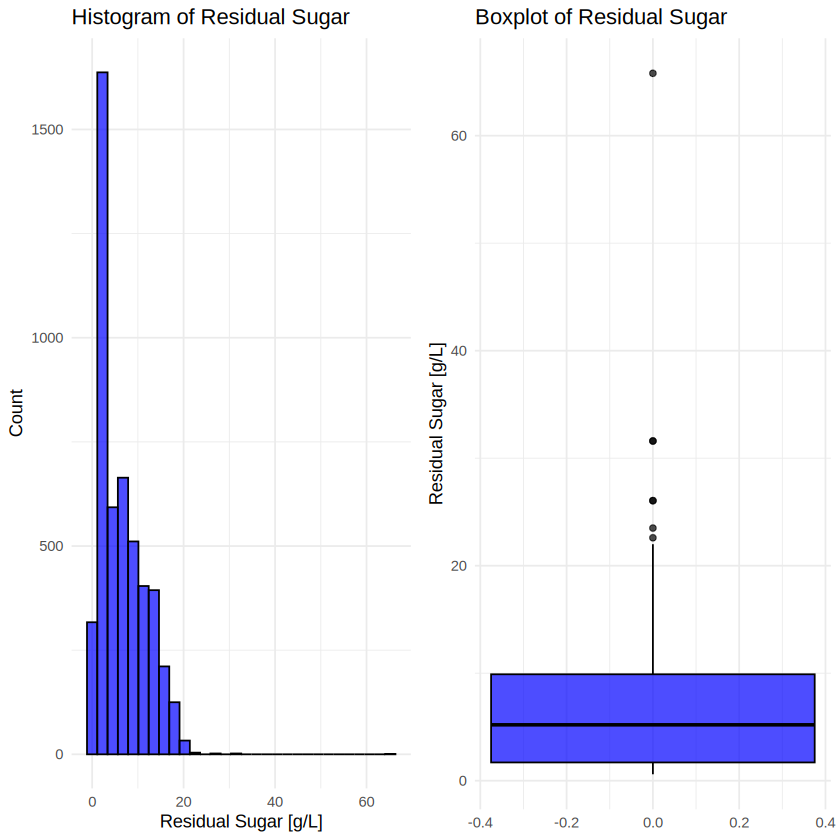

In [20]:
hist_plot <- ggplot(wine_quality_white, aes(x = residual.sugar)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Residual Sugar", x = "Residual Sugar [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_white, aes(y = residual.sugar)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of Residual Sugar", y = "Residual Sugar [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát phần trăm cồn trong rượu trắng

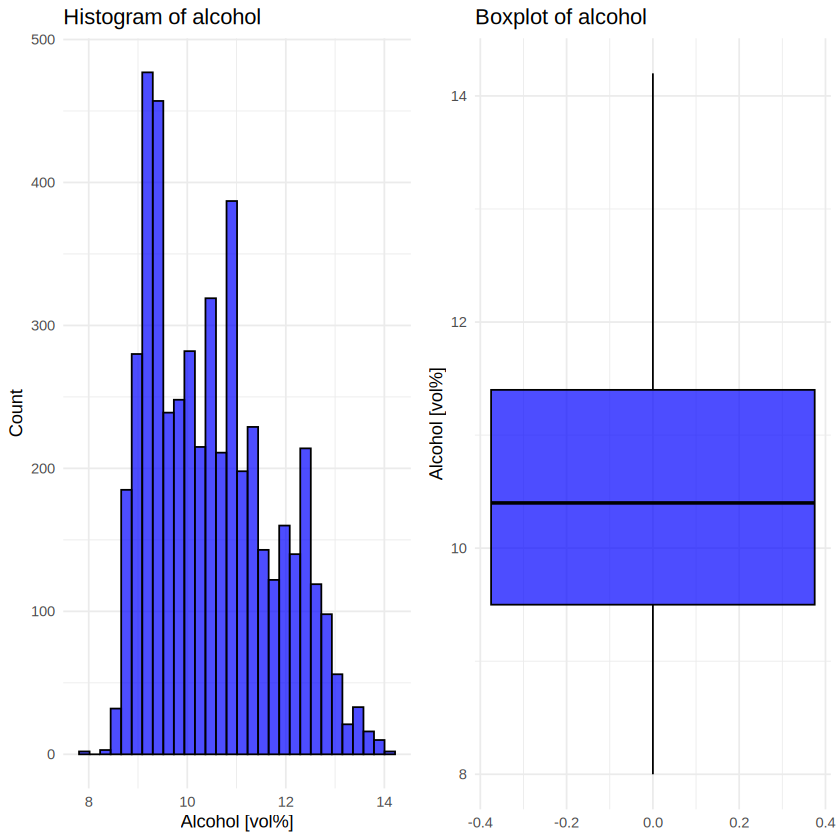

In [21]:
hist_plot <- ggplot(wine_quality_white, aes(x = alcohol)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of alcohol", x = "Alcohol [vol%]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_white, aes(y = alcohol)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of alcohol", y = "Alcohol [vol%]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát mật độ trong rượu trắng

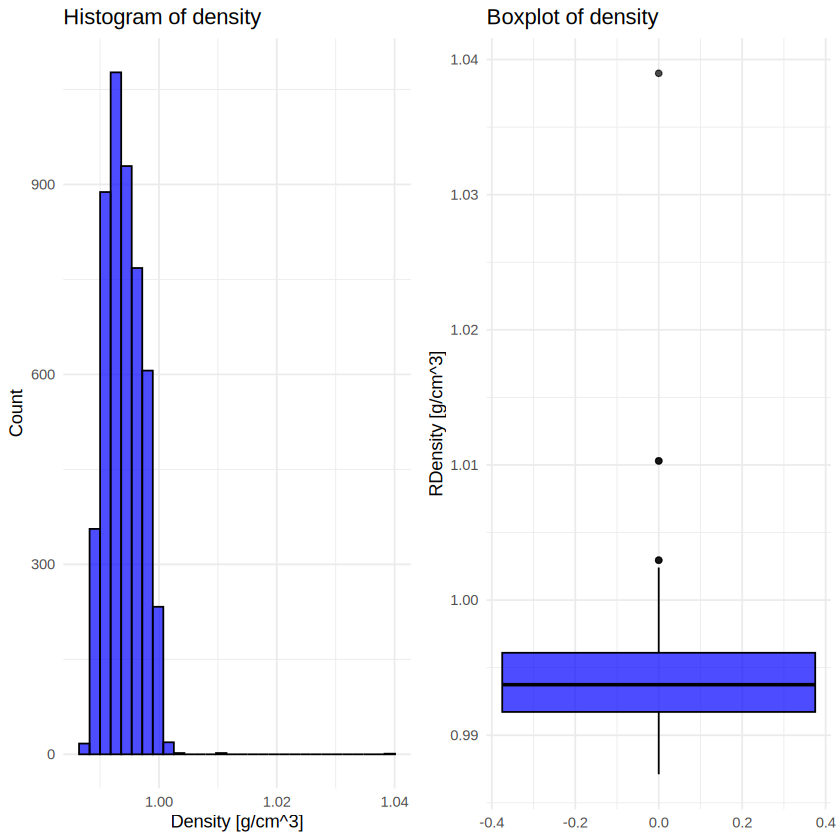

In [22]:
hist_plot <- ggplot(wine_quality_white, aes(x = density)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of density", x = "Density [g/cm^3]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_white, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of density", y = "RDensity [g/cm^3]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát lượng muối trong rượu trắng

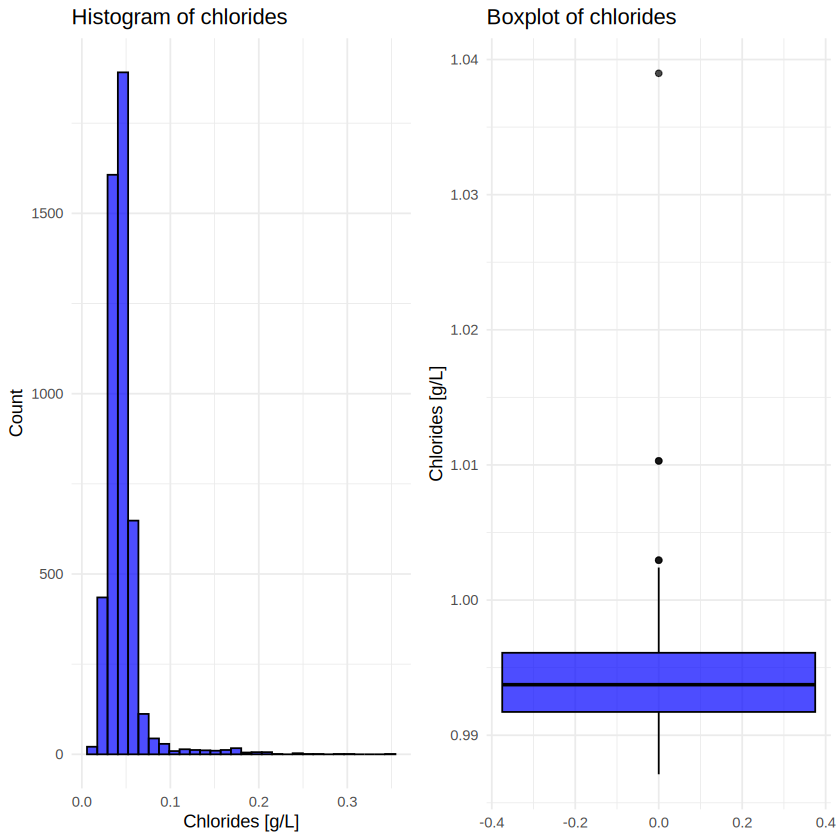

In [23]:
hist_plot <- ggplot(wine_quality_white, aes(x = chlorides)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of chlorides", x = "Chlorides [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality_white, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of chlorides", y = "Chlorides [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

## Phân tích đa biến

### Phân tích ma trận tương quan

corrplot 0.92 loaded


Attaching package: ‘corrplot’


The following object is masked from ‘package:pls’:

    corrplot




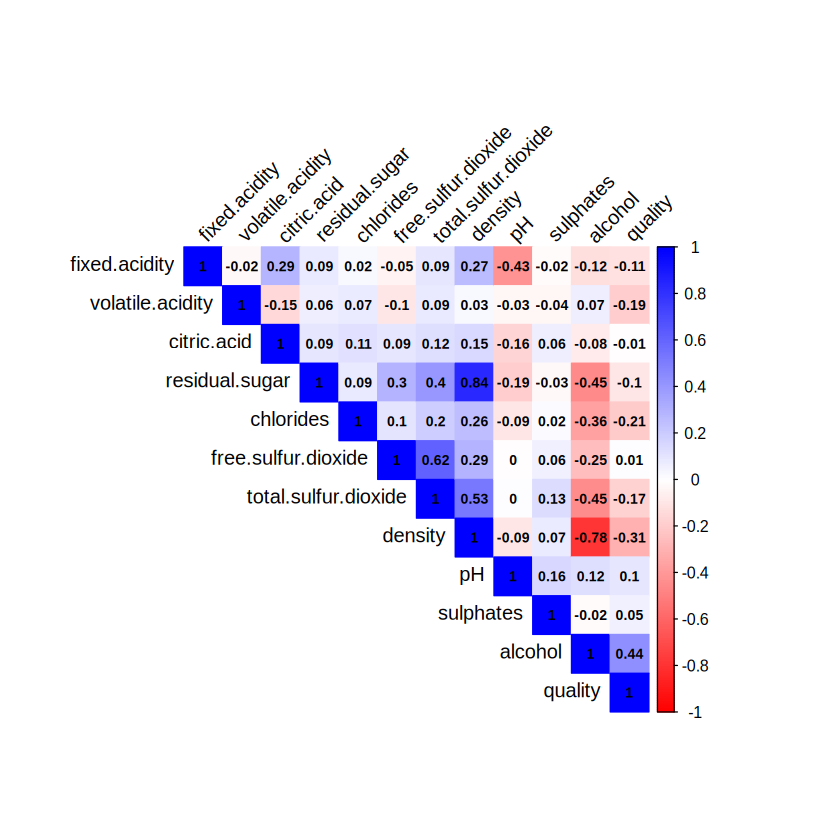

In [24]:
library(corrplot)

cor_matrix <- cor(wine_quality_white)

corrplot(cor_matrix, method = "color", type = "upper", 
         tl.col = "black", tl.srt = 45, addCoef.col = "black", number.cex = 0.7,
         col = colorRampPalette(c("red", "white", "blue"))(200))

In [25]:
threshold <- 0.3
positive_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) > threshold) {
      positive_cor_pairs <- rbind(positive_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(positive_cor_pairs)

                  Var1                 Var2     value
1       residual.sugar total.sulfur.dioxide 0.4014393
2       residual.sugar              density 0.8389665
3  free.sulfur.dioxide total.sulfur.dioxide 0.6155010
4 total.sulfur.dioxide              density 0.5298813
5              alcohol              quality 0.4355747


Chọn ngưỡng là 0.3, ta thấy:
- Nồng độ cồn (alcohol) có ảnh hưởng (thuận) đến chất lượng rượu (chỉ số tương quan 0.436)
- Các biến `residual.sugar` và `density` có tương quan thuận cao 0.83

In [26]:
threshold <- -0.3
negative_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) < threshold) {
      negative_cor_pairs <- rbind(negative_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(negative_cor_pairs)

                  Var1    Var2      value
1        fixed.acidity      pH -0.4258583
2       residual.sugar alcohol -0.4506312
3            chlorides alcohol -0.3601887
4 total.sulfur.dioxide alcohol -0.4488921
5              density alcohol -0.7801376
6              density quality -0.3071233


Chọn ngưỡng là 0.3, ta thấy:
- Mật độ trong rượu (`density`) có ảnh hưởng (nghịch) đến chất lượng của rượu (chỉ số tương quan -0.307)
- Các biến `alcohol` và `density` có tương quan nghịch cao -0.78

## Khảo sát đa cộng tuyến

In [27]:
model <- lm(quality ~ ., data = wine_quality_white)
vif_values <- vif(model)
print(vif_values)

       fixed.acidity     volatile.acidity          citric.acid 
            2.691435             1.141156             1.165215 
      residual.sugar            chlorides  free.sulfur.dioxide 
           12.644064             1.236822             1.787880 
total.sulfur.dioxide              density                   pH 
            2.239233            28.232546             2.196362 
           sulphates              alcohol 
            1.138540             7.706957 


In [28]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("quality ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [29]:
print(vif_values)
summary(model)

       fixed.acidity     volatile.acidity          citric.acid 
            1.356128             1.128298             1.159884 
      residual.sugar            chlorides  free.sulfur.dioxide 
            1.435215             1.203645             1.744627 
total.sulfur.dioxide                   pH            sulphates 
            2.153170             1.330912             1.056637 
             alcohol 
            1.647117 



Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    pH + sulphates + alcohol, data = wine_quality_white)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9098 -0.4957 -0.0330  0.4666  3.1785 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.0636371  0.3482321   5.926 3.32e-09 ***
fixed.acidity        -0.0503197  0.0149092  -3.375 0.000744 ***
volatile.acidity     -1.9583442  0.1138553 -17.200  < 2e-16 ***
citric.acid          -0.0289483  0.0961455  -0.301 0.763360    
residual.sugar        0.0256438  0.0025518  10.049  < 2e-16 ***
chlorides            -0.9525303  0.5425208  -1.756 0.079194 .  
free.sulfur.dioxide   0.0047672  0.0008391   5.682 1.41e-08 ***
total.sulfur.dioxide -0.0008697  0.0003730  -2.331 0.019771 *  
pH                    0.1651688  0.0825418   2.001 0.045444 *  
sulphates             0.4193440  0.

In [30]:
clean_df <- wine_quality_white[,names((vif_values))]
clean_df$quality <- wine_quality_white$quality
head(clean_df)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.0,0.27,0.36,20.7,0.045,45,170,3.00,0.45,8.8,6
2,6.3,0.30,0.34,1.6,0.049,14,132,3.30,0.49,9.5,6
3,8.1,0.28,0.40,6.9,0.050,30,97,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47,186,3.19,0.40,9.9,6
5,7.2,0.23,0.32,8.5,0.058,47,186,3.19,0.40,9.9,6
6,8.1,0.28,0.40,6.9,0.050,30,97,3.26,0.44,10.1,6


In [31]:
wine_quality_white <- clean_df

## Khảo sát ngoại lai

In [32]:
# Khảo sát ngoại lai theo biến diff
diff_data <- wine_quality_white
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: fixed.acidity"
[1] "Số ngoại lai: 119"
[1] "Số cực ngoại lai: 4"
[1] "Biến: volatile.acidity"
[1] "Số ngoại lai: 186"
[1] "Số cực ngoại lai: 39"
[1] "Biến: citric.acid"
[1] "Số ngoại lai: 270"
[1] "Số cực ngoại lai: 22"
[1] "Biến: residual.sugar"
[1] "Số ngoại lai: 7"
[1] "Số cực ngoại lai: 1"
[1] "Biến: chlorides"
[1] "Số ngoại lai: 208"
[1] "Số cực ngoại lai: 131"
[1] "Biến: free.sulfur.dioxide"
[1] "Số ngoại lai: 50"
[1] "Số cực ngoại lai: 8"
[1] "Biến: total.sulfur.dioxide"
[1] "Số ngoại lai: 19"
[1] "Số cực ngoại lai: 2"
[1] "Biến: pH"
[1] "Số ngoại lai: 75"
[1] "Số cực ngoại lai: 0"
[1] "Biến: sulphates"
[1] "Số ngoại lai: 124"
[1] "Số cực ngoại lai: 11"
[1] "Biến: alcohol"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: quality"
[1] "Số ngoại lai: 200"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 1040"
[1] "Tổng số cực ngoại lai: 206"


In [33]:
cleaned_df <- wine_quality_white[-extreme_outliners, ]
dim(cleaned_df)
dim(wine_quality_white)

[1] 4692   11

[1] 4898   11

In [34]:
wine_quality_white <- cleaned_df

## Chuẩn hóa dữ liệu

In [35]:
wine_quality_white <- bc_transform(wine_quality_white)
head(wine_quality_white)

[1] "fixed.acidity"
[1] "Optimal lambda: -2"
[1] "volatile.acidity"
[1] "Optimal lambda: -2"
[1] "citric.acid"
[1] "Optimal lambda: -2"
[1] "residual.sugar"
[1] "Optimal lambda: -2"
[1] "chlorides"
[1] "Optimal lambda: -2"
[1] "free.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "total.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "pH"
[1] "Optimal lambda: -2"
[1] "sulphates"
[1] "Optimal lambda: -2"
[1] "alcohol"
[1] "Optimal lambda: -2"
[1] "quality"
[1] "Optimal lambda: -2"


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4897959,-6.358711,0.2296713,0.4988331,-246.4136,0.4997531,0.4999827,0.4444444,-1.969136,0.4935434,0.4861111
2,0.4874024,-5.055556,0.2215415,0.3046875,-207.7466,0.4974490,0.4999713,0.4540863,-1.582466,0.4944598,0.4861111
3,0.4923792,-5.877551,0.2448980,0.4894980,-199.5000,0.4994444,0.4999469,0.4529527,-2.082645,0.4950985,0.4861111
4,0.4903549,-8.951796,0.2130395,0.4930796,-148.1326,0.4997737,0.4999855,0.4508653,-2.625000,0.4948985,0.4861111
5,0.4903549,-8.951796,0.2130395,0.4930796,-148.1326,0.4997737,0.4999855,0.4508653,-2.625000,0.4948985,0.4861111
6,0.4923792,-5.877551,0.2448980,0.4894980,-199.5000,0.4994444,0.4999469,0.4529527,-2.082645,0.4950985,0.4861111


## Phân chia tập dữ liệu

In [36]:
split_ratio <- 0.8
split_index <- floor(nrow(wine_quality_white) * split_ratio)

train = wine_quality_white[1:split_index,]
test = wine_quality_white[(split_index + 1):nrow(wine_quality_white),]

In [37]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 3753   11

In [38]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 939  11

In [39]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	3753 obs. of  11 variables:
 $ fixed.acidity       : num  0.49 0.487 0.492 0.49 0.49 ...
 $ volatile.acidity    : num  -6.36 -5.06 -5.88 -8.95 -8.95 ...
 $ citric.acid         : num  0.23 0.222 0.245 0.213 0.213 ...
 $ residual.sugar      : num  0.499 0.305 0.489 0.493 0.493 ...
 $ chlorides           : num  -246 -208 -199 -148 -148 ...
 $ free.sulfur.dioxide : num  0.5 0.497 0.499 0.5 0.5 ...
 $ total.sulfur.dioxide: num  0.5 0.5 0.5 0.5 0.5 ...
 $ pH                  : num  0.444 0.454 0.453 0.451 0.451 ...
 $ sulphates           : num  -1.97 -1.58 -2.08 -2.62 -2.62 ...
 $ alcohol             : num  0.494 0.494 0.495 0.495 0.495 ...
 $ quality             : num  0.486 0.486 0.486 0.486 0.486 ...


## Mô hình hóa hồi quy tuyến tính đa biến

### Xây dựng mô hình đầy đủ

In [40]:
full.lm <- lm(quality ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = quality ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041315 -0.002185  0.000655  0.002823  0.021928 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.812e+00  4.124e-01  -4.392 1.15e-05 ***
fixed.acidity        -1.314e-01  3.486e-02  -3.769 0.000166 ***
volatile.acidity     -1.271e-04  1.137e-05 -11.180  < 2e-16 ***
citric.acid           3.264e-03  1.759e-03   1.855 0.063604 .  
residual.sugar        4.787e-03  5.342e-04   8.962  < 2e-16 ***
chlorides            -8.546e-07  3.460e-07  -2.470 0.013565 *  
free.sulfur.dioxide   2.261e-01  2.051e-02  11.023  < 2e-16 ***
total.sulfur.dioxide  2.473e+00  8.303e-01   2.979 0.002911 ** 
pH                   -6.417e-03  1.933e-02  -0.332 0.739886    
sulphates             2.445e-04  7.289e-05   3.355 0.000803 ***
alcohol               2.040e+00  8.547e-02  23.867  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

### Lựa chọn mô hình tốt nhất

In [41]:
# Mô hình chặn dưới
model.lb <- lm(quality ~ 1, data = train)

In [42]:
# Mô hình chặn trên
model.up <- full.lm

In [43]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    sulphates + alcohol, data = train)

Coefficients:
         (Intercept)         fixed.acidity      volatile.acidity  
          -1.812e+00            -1.266e-01            -1.267e-04  
         citric.acid        residual.sugar             chlorides  
           3.298e-03             4.790e-03            -8.670e-07  
 free.sulfur.dioxide  total.sulfur.dioxide             sulphates  
           2.258e-01             2.467e+00             2.396e-04  
             alcohol  
           2.036e+00  


In [44]:
wqr_models <- regsubsets(quality ~ fixed.acidity + volatile.acidity + citric.acid + residual.sugar + chlorides + free.sulfur.dioxide + pH + sulphates + alcohol, data = train)
summary.wqr <-summary(wqr_models)

In [45]:
# Lựa chọn mô hình tốt nhất từ reg subsets
summary.wqr$which

,(Intercept),fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,pH,sulphates,alcohol
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
3,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
4,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE
5,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE
6,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE
7,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
8,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [46]:
summary.wqr$rsq

[1] 0.1285501 0.1805982 0.2015703 0.2192529 0.2222196 0.2246046 0.2253978
[8] 0.2261826

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [47]:
# model with largest adjusted R^2
summary.wqr$adjr2

[1] 0.1283178 0.1801611 0.2009314 0.2184196 0.2211817 0.2233626 0.2239499
[8] 0.2245292

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [48]:
# model with smallest Mallow's Cp
summary.wqr$cp

[1] 466.332492 216.568453 117.122869  33.589825  21.239379  11.702782   9.866046
[8]   8.069521

#### Chọn mô hình tốt nhất dựa trên BIC

In [49]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.wqr$bic

[1] -499.9407 -722.8341 -811.9106 -887.7308 -893.7885 -897.0841 -892.6949
[8] -888.2692

In [50]:
best_model_index <- which.min(summary.wqr$bic)
best_model <- summary.wqr$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

        (Intercept)       fixed.acidity    volatile.acidity         citric.acid 
               TRUE                TRUE                TRUE               FALSE 
     residual.sugar           chlorides free.sulfur.dioxide                  pH 
               TRUE               FALSE                TRUE               FALSE 
          sulphates             alcohol 
               TRUE                TRUE 
[1] "fixed.acidity"       "volatile.acidity"    "residual.sugar"     
[4] "free.sulfur.dioxide" "sulphates"           "alcohol"            


In [51]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("quality ~", paste(best_vars, collapse = " + "))
best_model_wqr <- lm(as.formula(formula_str), data=train)

In [52]:
# Tóm tắt mô hình
summary(best_model_wqr)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041608 -0.002218  0.000647  0.002862  0.024640 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -6.348e-01  4.355e-02 -14.576  < 2e-16 ***
fixed.acidity       -1.091e-01  2.976e-02  -3.667 0.000249 ***
volatile.acidity    -1.279e-04  1.118e-05 -11.432  < 2e-16 ***
residual.sugar       4.993e-03  5.319e-04   9.388  < 2e-16 ***
free.sulfur.dioxide  2.482e-01  1.874e-02  13.243  < 2e-16 ***
sulphates            2.405e-04  7.085e-05   3.394 0.000695 ***
alcohol              2.113e+00  7.701e-02  27.431  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004705 on 3746 degrees of freedom
Multiple R-squared:  0.2246,	Adjusted R-squared:  0.2234 
F-statistic: 180.8 on 6 and 3746 DF,  p-value: < 2.2e-16


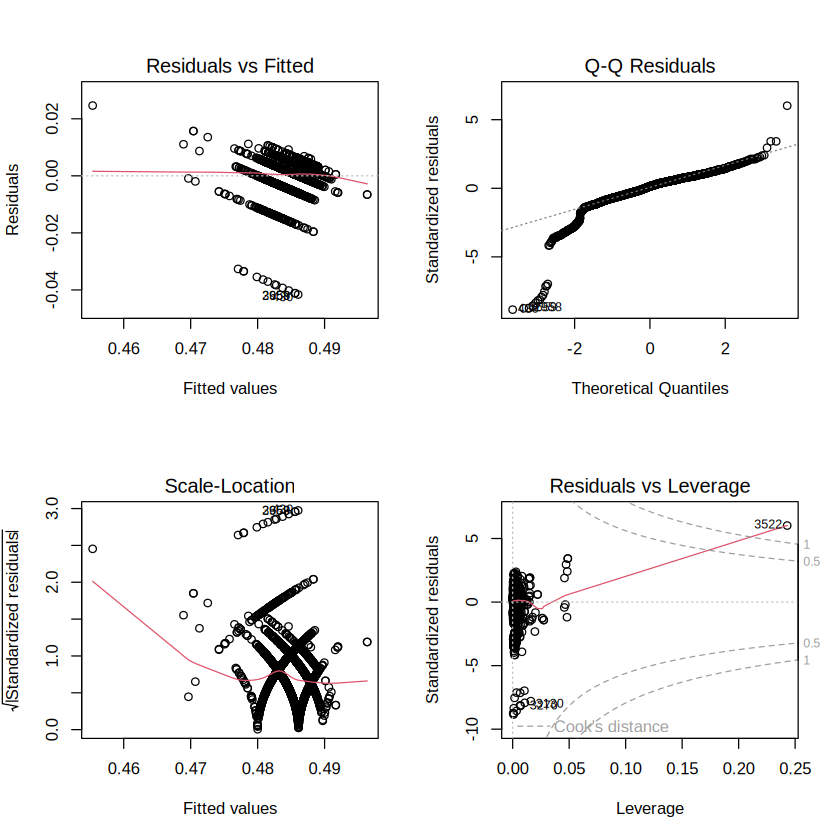

In [53]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_wqr)

#### Phân tích Residuals vs Fitted Plot

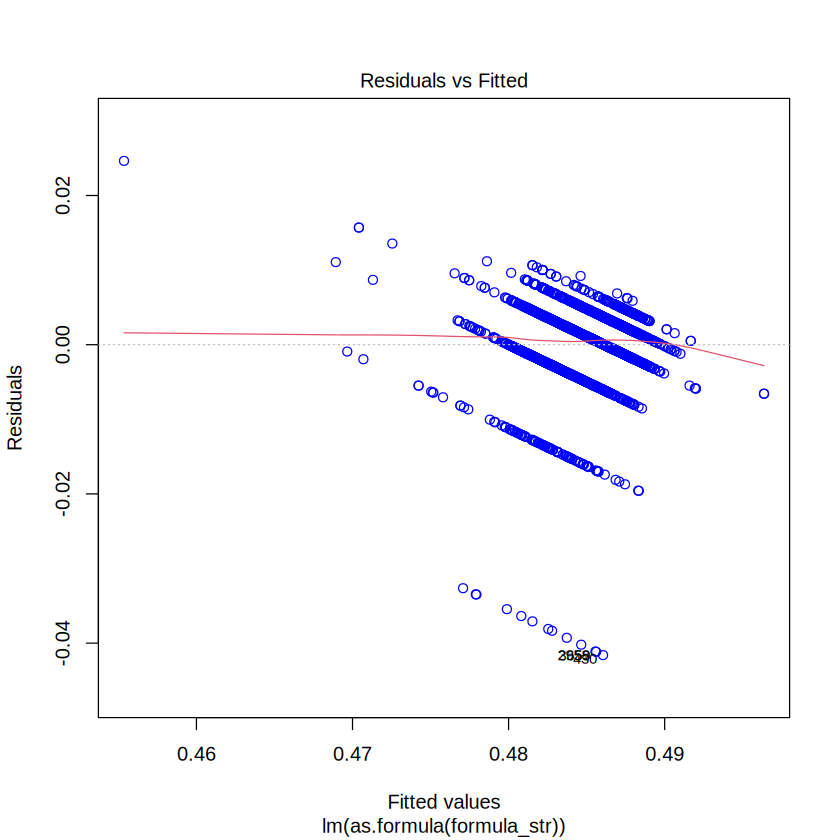

In [54]:
plot(best_model_wqr, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Phân tích Normal Q–Q (quantile-quantile) Plot


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.8476, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


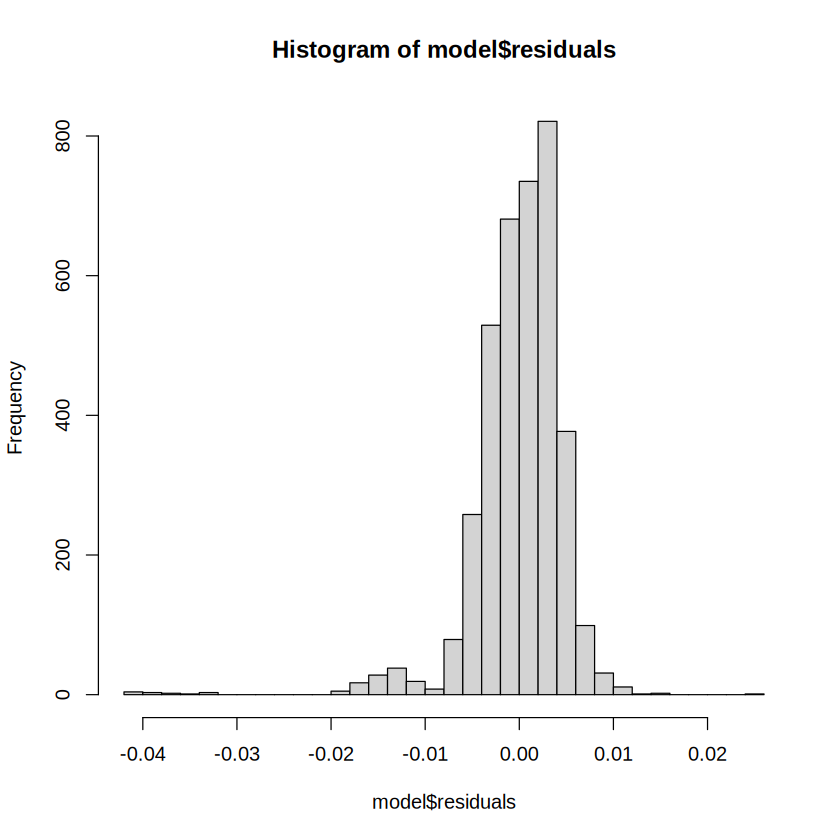

In [55]:
CheckNormal(model = best_model_wqr)

#### Phân tích Scale-Location


	studentized Breusch-Pagan test

data:  model
BP = 140.19, df = 6, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


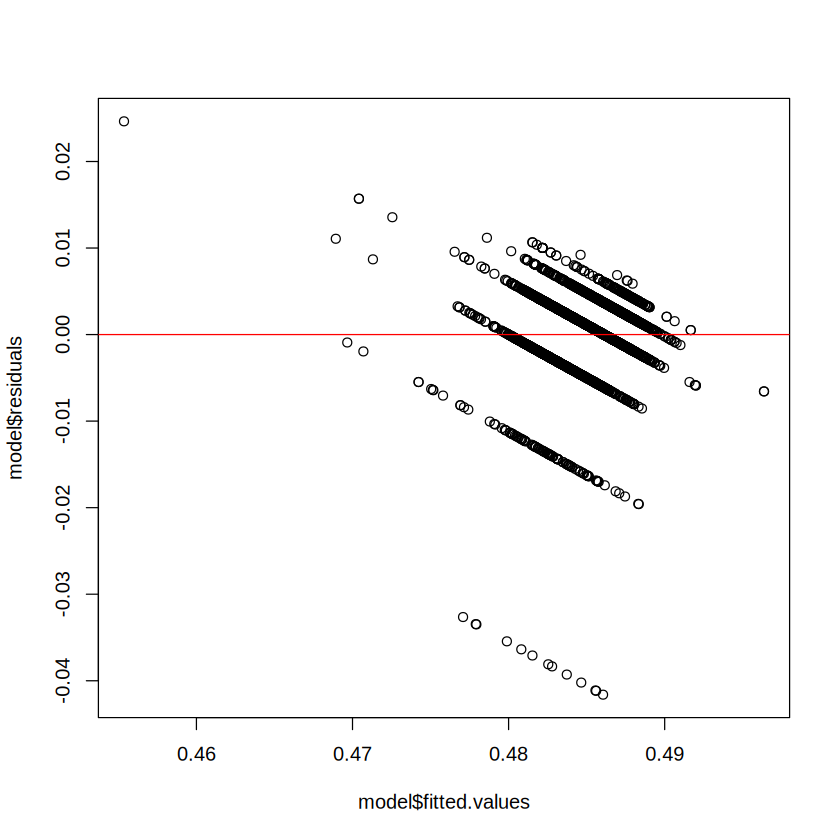

In [56]:
CheckHomos(best_model_wqr)

In [57]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.001065814


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0166893 -0.0023873  0.0003377  0.0024127  0.0100025 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -6.041e-01  3.454e-02 -17.491  < 2e-16 ***
fixed.acidity       -1.045e-01  2.198e-02  -4.757 2.04e-06 ***
volatile.acidity    -1.204e-04  8.890e-06 -13.545  < 2e-16 ***
residual.sugar       3.923e-03  4.238e-04   9.257  < 2e-16 ***
free.sulfur.dioxide  2.933e-01  2.763e-02  10.617  < 2e-16 ***
sulphates            1.746e-04  5.226e-05   3.340 0.000847 ***
alcohol              2.002e+00  5.626e-02  35.589  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003329 on 3570 degrees of freedom
Multiple R-squared:  0.3039,	Adjusted R-squared:  0.3027 
F-statistic: 259.8 on 6 and 3570 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98474, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


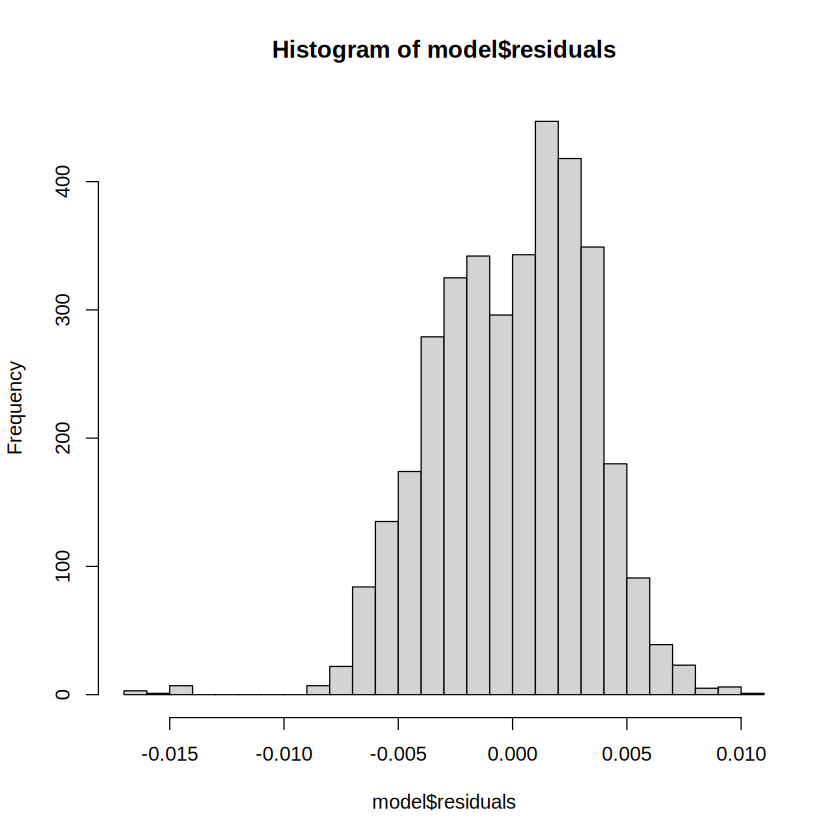


	studentized Breusch-Pagan test

data:  model
BP = 49.612, df = 6, p-value = 5.622e-09

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


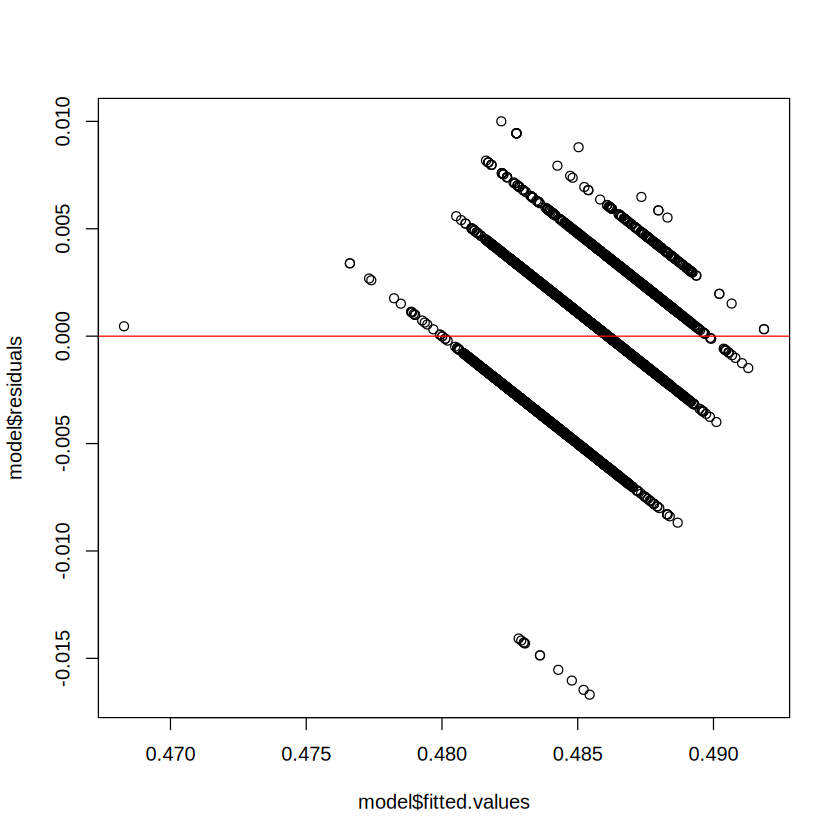

In [58]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_wqr.2))
CheckNormal(best_model_wqr.2)

# Breusch-Pagan Test
# bptest(best_model_wqr.2)
CheckHomos(best_model_wqr.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041606 -0.002186  0.000671  0.002839  0.024260 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -6.415e-01  4.438e-02 -14.456  < 2e-16 ***
fixed.acidity       -1.135e-01  3.036e-02  -3.737 0.000189 ***
volatile.acidity    -1.276e-04  1.137e-05 -11.223  < 2e-16 ***
residual.sugar       4.998e-03  5.442e-04   9.184  < 2e-16 ***
free.sulfur.dioxide  2.450e-01  1.897e-02  12.918  < 2e-16 ***
sulphates            2.651e-04  7.239e-05   3.661 0.000255 ***
alcohol              2.134e+00  7.849e-02  27.184  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004713 on 3613 degrees of freedom
Multiple R-squared:  0.2269,	Adjusted R-squared:  0.2256 
F-statistic: 176.7 on 6 and 3613 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.84414, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


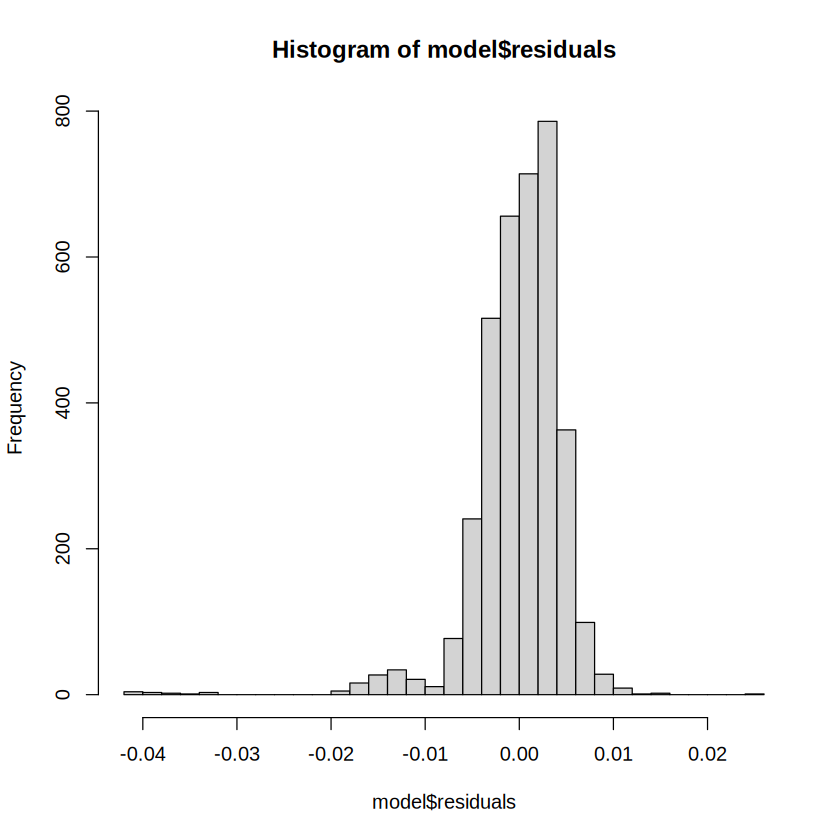


	studentized Breusch-Pagan test

data:  model
BP = 133.54, df = 6, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


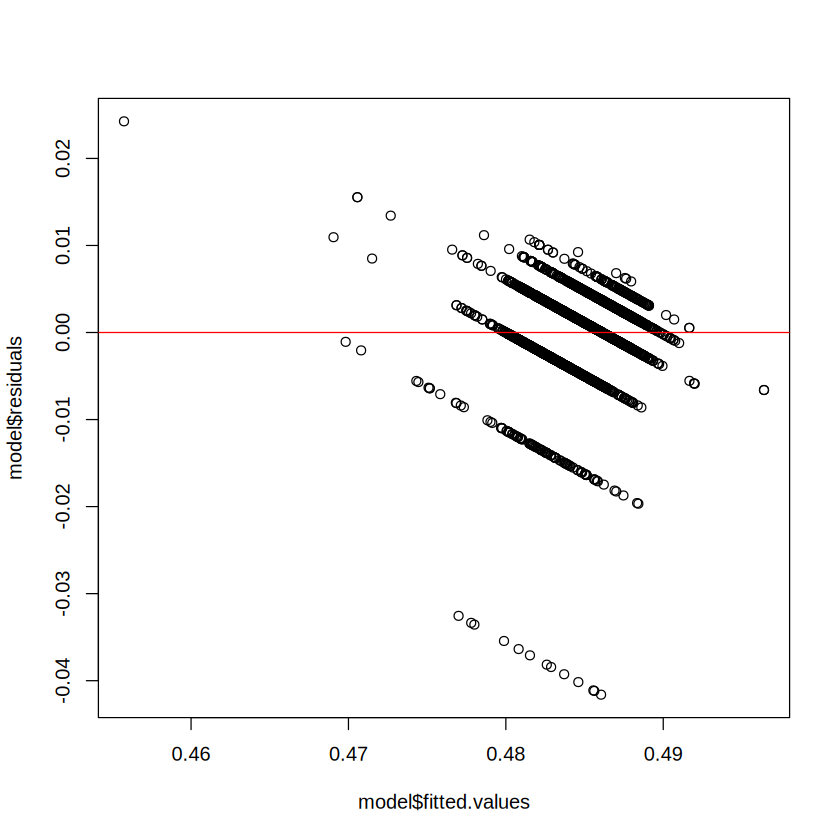

In [59]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_wqr.3)

# Breusch-Pagan Test
CheckHomos(best_model_wqr.3)

## Đánh giá hiệu suất và dự đoán kết quả

[1] "MSE: 1.5e-05"
[1] "RMSE: 0.003887"
[1] "MAE: 0.002809"
[1] "Correlation: 0.478078"
[1] "R^2 between y_pred & y_true: 0.228558"


[1] 0.003886742

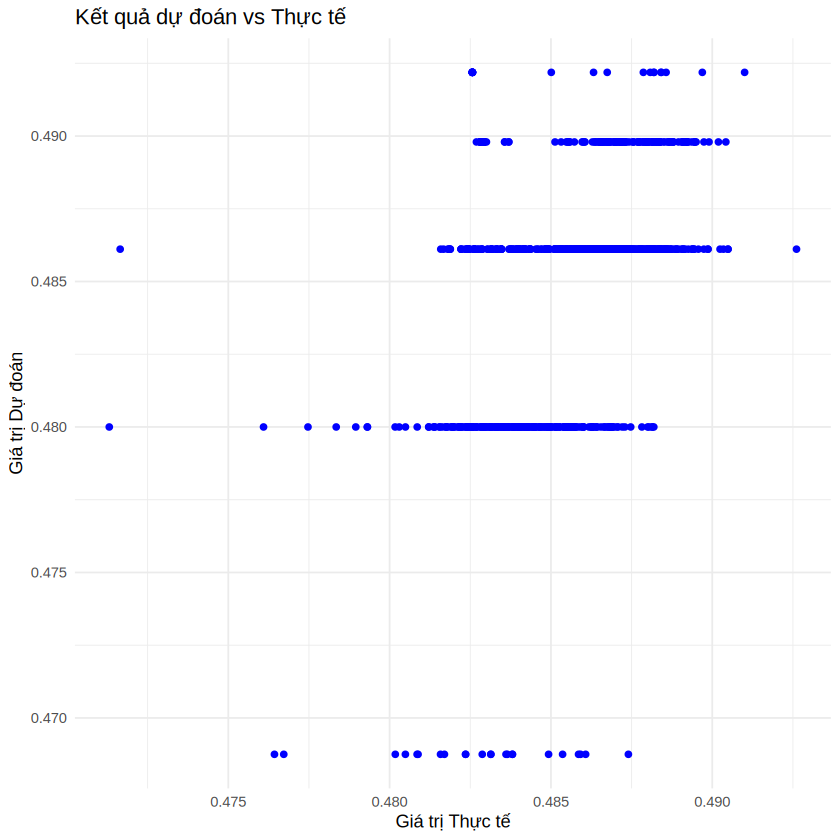

In [60]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_wqr.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$quality
)

metrics(results, test$quality)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$quality)

In [61]:
print(best_model_wqr.2)


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Coefficients:
        (Intercept)        fixed.acidity     volatile.acidity  
         -0.6041273           -0.1045400           -0.0001204  
     residual.sugar  free.sulfur.dioxide            sulphates  
          0.0039231            0.2933424            0.0001746  
            alcohol  
          2.0023690  



## Kết luận

Dựa trên quá trình mô hình hóa, ta thu được mô hình

```
quality = fixed.acidity + volatile.acidity + residual.sugar + free.sulfur.dioxide + sulphate + alcohol
```

với các hệ số:

```
Coefficients:
(Intercept)        fixed.acidity     volatile.acidity  
         -0.6041273           -0.1045400           -0.0001204  
     residual.sugar  free.sulfur.dioxide            sulphates  
          0.0039231            0.2933424            0.0001746  
            alcohol  
          2.0023690  
```

Điều này có nghĩa là:
- Chất lượng rượu phụ thuộc vào nồng độ cồn, nồng độ cồn càng cao, chất lượng rượu càng tăng
- Các chỉ số về tính chua khiến chất lượng của rượu bị giảm.
- Lượng đường, muối nhỏ có thể giúp rượu trắng ngon hơn.
- Khí SO2 có tác động tích cực đến chất lượng rượu trắng
